In [3]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random

In [4]:
from layers import CompressionLayer, QuantizationLayer, FeatureSelectionLayer, HardQuantizationLayer, HardQuantizationThresholdLayer
from models import MultiLayerPerceptron
from datasets import get_dataloader
from training_utils import train_model, eval_val, eval_quantization

In [5]:
from joblib import Parallel, delayed

## Load Dataset

In [6]:
dataset = 'California_Housing'
train_loader, val_loader, test_loader = get_dataloader(dataset = dataset)

In [8]:
def estimate_quantile(train_loader, quantiles):
    all_data = []

    # Collect all data from the train_loader
    for batch in train_loader:
        inputs, _ = batch
        all_data.append(inputs)

    # Concatenate all data along the first dimension
    all_data = torch.cat(all_data, dim=0)
    quantile_values = torch.quantile(all_data, quantiles, dim=0).transpose(0,1)
    return quantile_values

def get_quantization_thresholds(train_loader, n_bits):
    thresholds = 2 ** n_bits - 1
    quantiles = torch.arange(1 / (thresholds + 1), 1, 1 / (thresholds + 1))
    thresholds = estimate_quantile(train_loader, quantiles)
    return thresholds


### Grid Search for DNN with SoftQuantizationLayer

In [8]:
hidden_neurons = [128, 256, 512, 1024]
max_hidden_layers = 6
neuron_combinations = [[hidden_neuron] for hidden_neuron in hidden_neurons]
neuron_combination_dict = {1: neuron_combinations}
neuron_combinations = []
for current_layers in range(2,max_hidden_layers + 1):
    current_lists = neuron_combination_dict.get(current_layers-1)
    new_lists = []
    for current_list in current_lists:
        for hidden_neuron in hidden_neurons:
            new_list = current_list + [hidden_neuron]
            ## Only add new_list, if it first goes up in neurons and then down
            # if (np.diff(np.sign(np.diff(np.array(new_list)))) <= 0).all() & np.count_nonzero(np.diff(np.sign(np.diff(np.array(new_list))))) <=1:
            ## Only add new_list, if it first goes up in neurons and then down and only has 2 values    
            if ((np.diff(np.sign(np.diff(np.array(new_list)))) <= 0).all()) & (np.count_nonzero(np.diff(np.sign(np.diff(np.array(new_list))))) <=2) & (len(np.unique(np.array(new_list))) <= 3):
                new_lists.append(new_list)
    neuron_combination_dict.update({current_layers: new_lists})
    if current_layers > 3:
        neuron_combinations += new_lists

print(len(neuron_combinations))

170


In [9]:
device = 'cuda'

In [10]:
def random_search_soft_quantization_threshold(n_steps = 10, n_bits =8, optimize_dict = {}, device = 'cpu'):
    thresholds = get_quantization_thresholds(train_loader, n_bits)

    # Define default hyperparameters
    weight_decay =  0
    learning_rate = 0.001
    neuron_combination = [256,256]
    num_epochs = 30
    add_noise = False
    decrease_factor = 0.001

    # Lists to store results
    random_search_losses = []
    hyperparameter_dict = {
        'weight_decay': [],
        'learning_rate': [],
        'architecture': [],
        'num_epochs': [],
        'add_noise': [],
        'decrease_factor': []}
    

    # Perform random search
    for _ in tqdm(range(n_steps)):
        for key, value in optimize_dict.items():
            if key == 'weight_decay':
                weight_decay = random.choice(value)
            elif key == 'learning_rate':
                learning_rate = random.choice(value)
            elif key == 'neuron_combination':
                neuron_combination = random.choice(value)
            elif key == 'num_epochs':
                num_epochs = random.choice(value)    
            elif key == 'add_noise':
                add_noise = random.choice(value)    
            elif key == 'decrease_factor':
                decrease_factor = random.choice(value)
            else:
                raise ValueError(f"Unknown hyperparameter: {key}")
            
        architecture = [8] + neuron_combination + [1]
        hyperparameter_dict['weight_decay'].append(weight_decay)
        hyperparameter_dict['learning_rate'].append(learning_rate)
        hyperparameter_dict['architecture'].append(neuron_combination)
        hyperparameter_dict['num_epochs'].append(num_epochs)
        hyperparameter_dict['add_noise'].append(add_noise)

        quantization_model = QuantizationLayer(num_features = thresholds.shape[0], num_thresholds_per_feature=thresholds.shape[1],tau = 1)
        quantization_model.set_thresholds(thresholds)
        mlp = MultiLayerPerceptron(architecture)
        model = nn.Sequential(
            quantization_model,
            mlp
        )
        

        model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        best_val_loss = train_model(model, num_epochs=num_epochs,
                    train_loader=train_loader, test_loader=test_loader, decrease_factor=decrease_factor,
                    optimizer=optimizer, criterion=criterion, has_quantization_layer=True,
                    train_quantization_layer=True, print_result=False,
                    add_noise=add_noise, device=device)

        val_loss = eval_val(model=model,
                val_dataloader=test_loader,
                criterion=criterion, device = device)
        
        random_search_losses.append(best_val_loss)
 
    # Create DataFrame with results
    results_df = pd.DataFrame({
        'Architecture': hyperparameter_dict['architecture'],
        'Loss': random_search_losses,
        'Weight Decay': hyperparameter_dict['weight_decay'],
        'Learning Rate': hyperparameter_dict['learning_rate'],
        'Num Epochs': hyperparameter_dict['num_epochs'],
        'Add Noise': hyperparameter_dict['add_noise'],
        'Decrease Factor': hyperparameter_dict['decrease_factor']
    })
    results_df = results_df.sort_values('Loss')  # Sort by loss ascending    
    return results_df

In [11]:
results_df_soft = random_search_soft_quantization_threshold( n_bits = 8,
                                              n_steps = 150,
                                              optimize_dict=
                                              {'weight_decay': [0, 0.0001],
                                              'learning_rate': [0.001, 0.0001],
                                              'add_noise': [False, True],
                                              'neuron_combination': neuron_combinations,
                                              'num_epochs': [10,30,50],
                                              'decrease_factor': [0.001, 0.0001]},
                                              device = device)

100%|██████████| 150/150 [52:25<00:00, 20.97s/it] 


In [12]:
results_df_soft.head()

,Architecture,Loss,Weight Decay,Learning Rate,Num Epochs,Add Noise
87,"[128, 256, 256, 256, 128]",0.266940,0.0000,0.001,50,False
98,"[1024, 1024, 1024, 1024, 1024, 1024]",0.273487,0.0000,0.001,50,False
41,"[512, 1024, 1024, 1024, 1024, 256]",0.275008,0.0001,0.001,50,False
32,"[256, 1024, 1024, 1024, 1024, 256]",0.276937,0.0000,0.001,50,False
86,"[128, 512, 1024, 1024, 1024, 512]",0.276987,0.0001,0.001,50,False


In [13]:
results_df_soft.to_csv(f'results/{dataset}/random_search_results_soft_quantization.csv', index=False)

### Grid Search for DNN with SoftCompressionLayer

In [33]:
def random_search_soft_compression_threshold(n_steps = 10, n_bits =8, optimize_dict = {}, device = 'cpu'):
    thresholds = get_quantization_thresholds(train_loader, n_bits)

    # Define default hyperparameters
    weight_decay =  0
    learning_rate = 0.001
    neuron_combination = [256,256]
    num_epochs = 30
    add_noise = False
    decrease_factor = 0.001

    # Lists to store results
    random_search_losses = []
    hyperparameter_dict = {
        'weight_decay': [],
        'learning_rate': [],
        'architecture': [],
        'num_epochs': [],
        'add_noise': [],
        'decrease_factor': []}
    

    # Perform random search
    for _ in tqdm(range(n_steps)):
        for key, value in optimize_dict.items():
            if key == 'weight_decay':
                weight_decay = random.choice(value)
            elif key == 'learning_rate':
                learning_rate = random.choice(value)
            elif key == 'neuron_combination':
                neuron_combination = random.choice(value)
            elif key == 'num_epochs':
                num_epochs = random.choice(value)    
            elif key == 'add_noise':
                add_noise = random.choice(value)    
            elif key == 'decrease_factor':
                decrease_factor = random.choice(value)
            else:
                raise ValueError(f"Unknown hyperparameter: {key}")
            
        architecture = [(2**8-1)*8] + neuron_combination + [1]
        hyperparameter_dict['weight_decay'].append(weight_decay)
        hyperparameter_dict['learning_rate'].append(learning_rate)
        hyperparameter_dict['architecture'].append(neuron_combination)
        hyperparameter_dict['num_epochs'].append(num_epochs)
        hyperparameter_dict['add_noise'].append(add_noise)
        hyperparameter_dict['decrease_factor'].append(decrease_factor)

        quantization_model = CompressionLayer(a_init = thresholds.flatten(), a_index = torch.repeat_interleave(torch.arange(8),2**8-1), tau = 1)
        # CompressionLayer(num_features = thresholds.shape[0], num_thresholds_per_feature=thresholds.shape[1],tau = 1)
        # quantization_model.set_thresholds(thresholds)
        mlp = MultiLayerPerceptron(architecture)
        model = nn.Sequential(
            quantization_model,
            mlp
        )
        

        model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        best_val_loss = train_model(model, num_epochs=num_epochs,
                    train_loader=train_loader, test_loader=test_loader, decrease_factor=decrease_factor,
                    optimizer=optimizer, criterion=criterion, has_quantization_layer=True,
                    train_quantization_layer=True, print_result=False,
                    add_noise=add_noise, device=device)

        val_loss = eval_val(model=model,
                val_dataloader=test_loader,
                criterion=criterion, device = device)
        
        random_search_losses.append(best_val_loss)
 
    # Create DataFrame with results
    results_df = pd.DataFrame({
        'Architecture': hyperparameter_dict['architecture'],
        'Loss': random_search_losses,
        'Weight Decay': hyperparameter_dict['weight_decay'],
        'Learning Rate': hyperparameter_dict['learning_rate'],
        'Num Epochs': hyperparameter_dict['num_epochs'],
        'Add Noise': hyperparameter_dict['add_noise'],
        'Decrease Factor': hyperparameter_dict['decrease_factor']
    })
    results_df = results_df.sort_values('Loss')  # Sort by loss ascending    
    return results_df

In [35]:
results_df_soft_compression = random_search_soft_compression_threshold( n_bits = 8,
                                              n_steps = 150,
                                              optimize_dict=
                                              {'weight_decay': [0, 0.0001],
                                              'learning_rate': [0.001, 0.0001],
                                              'add_noise': [False, True],
                                              'neuron_combination': neuron_combinations,
                                              'num_epochs': [30,50,70],
                                              'decrease_factor': [0.001, 0.0001]},
                                              device = device)

100%|██████████| 150/150 [1:31:50<00:00, 36.74s/it]


In [36]:
results_df_soft_compression.head()

,Architecture,Loss,Weight Decay,Learning Rate,Num Epochs,Add Noise,Decrease Factor
13,"[128, 128, 128, 128]",0.222251,0.0001,0.0001,70,False,0.0010
70,"[256, 1024, 1024, 256]",0.222841,0.0001,0.0001,30,False,0.0010
45,"[1024, 1024, 512, 128]",0.223592,0.0001,0.0001,50,False,0.0001
88,"[256, 512, 512, 512, 512]",0.224757,0.0000,0.0001,30,False,0.0001
23,"[128, 512, 1024, 1024, 1024, 512]",0.224842,0.0001,0.0001,50,False,0.0001


In [ ]:
results_df_soft_compression.to_csv(f'results/{dataset}/random_search_results_soft_quantization_compression.csv', index=False)

## Try out single architecture

In [14]:
num_features = 8
n_bits = 4
n_thresholds_per_feature = (2**n_bits-1)
n_thresholds = num_features*n_thresholds_per_feature
architecture = [n_thresholds,256,256,256,1]

learning_rate = 0.0001
weight_decay = 0.0001
num_epochs = 70
device = 'cuda'
decrease_factor = 0.0001

In [11]:
architecture

[120, 256, 256, 256, 1]

In [21]:
val_losses = []
for f in tqdm(range(20)):
    thresholds = get_quantization_thresholds(train_loader, n_bits)
    quantization_model = CompressionLayer(a_init = thresholds.flatten(), a_index = torch.repeat_interleave(torch.arange(num_features),n_thresholds_per_feature), tau = 1)
    # CompressionLayer(num_features = thresholds.shape[0], num_thresholds_per_feature=thresholds.shape[1],tau = 1)
    # quantization_model.set_thresholds(thresholds)
    mlp = MultiLayerPerceptron(architecture)
    model = nn.Sequential(
        quantization_model,
        mlp
    )
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_loss = train_model(model, num_epochs=num_epochs,
                train_loader=train_loader, test_loader=test_loader, decrease_factor=decrease_factor,
                optimizer=optimizer, criterion=criterion, has_quantization_layer=True,
                train_quantization_layer=True, print_result=False,
                add_noise=False, device=device)

    val_loss = eval_val(model=model,
            val_dataloader=test_loader,
            criterion=criterion, device = device)
    val_losses.append(val_loss)

100%|██████████| 20/20 [19:54<00:00, 59.74s/it] 


{'whiskers': [<matplotlib.lines.Line2D at 0x7eff90048260>,
 'caps': [<matplotlib.lines.Line2D at 0x7eff90049730>,
 'boxes': [<matplotlib.lines.Line2D at 0x7eff90048650>],
 'medians': [<matplotlib.lines.Line2D at 0x7eff9004a120>],
 'fliers': [<matplotlib.lines.Line2D at 0x7eff9004a7b0>],
 'means': []}

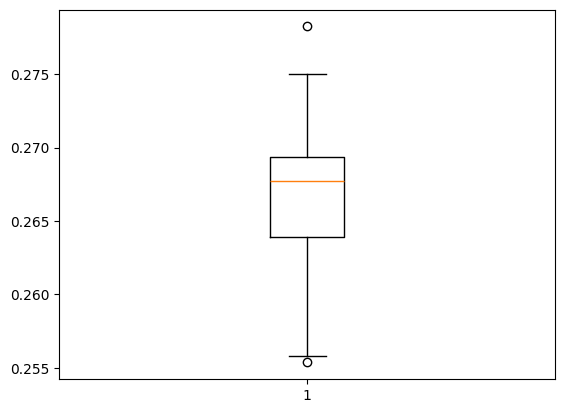

In [22]:
plt.boxplot(val_losses)

In [23]:
print('Validation Losses of soft layers')
val_losses

Validation Losses of soft layers


[0.27012983445937816,
 0.2648538202047348,
 0.2782393808548267,
 0.26741580023215367,
 0.26477311436946577,
 0.25757721330110844,
 0.2679829003719183,
 0.26796831007187183,
 0.2687665666525181,
 0.25583835656826315,
 0.2607624753163411,
 0.2715140537573741,
 0.27500283328386455,
 0.2553736108999986,
 0.2647632332948538,
 0.26911976784467695,
 0.2687500990354098,
 0.27216559396340295,
 0.2614028045764336,
 0.2664514261942643]

In [18]:
input = torch.randn(65,8).to(device)
quant_output = quantization_model(input)
print(quant_output.shape)
output = mlp(quant_output)
print(output.shape)

torch.Size([65, 120])
torch.Size([65, 1])
